<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep conv net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an ipython notebook via learningsuite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 30% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracy
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**

**DONE:**
* Watch tutorial

In [0]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [0]:
# Use the dataset class you created in lab2
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root,
                                      train=train,
                                      transform=transforms.ToTensor(),
                                      download=True)
  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y

  def __len__(self):
    return len(self.data)

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropy loss function.

**TODO:**

**DONE:**
* Conv2D
* CrossEntropyLoss 
___

### Part 2
Implement a few initialization strategies which can include Xe initialization
(sometimes called Xavier), Orthogonal initialization, and uniform random.
You can specify which strategy you want to use with a parameter. 



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**

**DONE:**
* Parameterize custom Conv2D for different initilization strategies
* Uniform
* Orthogonal
* Xe



In [0]:
class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean'):
    super(CrossEntropyLoss, self).__init__()
    self.weight = weight
    self.size_average = size_average
    self.ignore_index = ignore_index
    self.reduce = reduce
    self.reduction = reduction

  def forward(self, yHat, yTruth):
    #yHat = batch size x number of classes
    #tTruth = batch size (each entry is the index of the correct class)

    #calculate losses
    incorrectPredictionScores = torch.log(torch.sum(torch.exp(yHat), dim=1))
    batchSize, classes = yHat.size()
    indexMatrix = torch.zeros((batchSize, classes)).cuda() #call to cuda is inside the torch.sum call two lines down in the TA's code
    indexMatrix[np.arange(batchSize), yTruth] = 1
    correctPredictionScores = torch.sum(yHat * indexMatrix, dim=1)
    preReductionLosses = incorrectPredictionScores - correctPredictionScores

    if self.reduction == 'mean':
      return torch.mean(preReductionLosses)
    elif self.reduction == 'sum':
      return torch.sum(preReductionLosses)
    
    return preReductionLosses

def measureAccuracy(yHat, yTruth):
  #yHat = batch size x number of classes
  #tTruth = batch size (each entry is the index of the correct class)

  _, predicted = torch.max(yHat.data, 1)
  total = yTruth.size(0)
  correct = (predicted == yTruth).sum().item()

  return 100 * (correct / total)

class Conv2d(nn.Module):
  def __init__(self, initStrategy, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'):
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = padding
    self.dilation = dilation
    self.groups = groups
    self.bias = bias
    self.padding_mode = padding_mode

    super(Conv2d, self).__init__()

    self.weight = Parameter(torch.Tensor(out_channels, in_channels, *kernel_size))
    self.bias = Parameter(torch.Tensor(out_channels))

    self.bias.data.uniform_(0,0)

    #Change initializations
    if initStrategy == 'xavier':
      nn.init.xavier_uniform_(self.weight)
    elif initStrategy == 'orthogonal':
      initialMatrix = np.random.random((self.out_channels, self.in_channels * kernel_size[0] * kernel_size[1])).astype(np.float32)
      U, _, Vt = np.linalg.svd(initialMatrix, full_matrices=False)
      if len(initialMatrix) > len(initialMatrix[0]):
        weights = U.reshape((self.out_channels, self.in_channels, kernel_size[0], kernel_size[1]))
      else:
        weights = Vt.reshape((self.out_channels, self.in_channels, kernel_size[0], kernel_size[1]))
      self.weight.data = torch.from_numpy(weights)
    elif initStrategy == 'uniform':
      self.weight.data.uniform_(-1,1)
    else:
      nn.init.xavier_uniform_(self.weight)

  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


In [22]:
#predictions = np.random.rand(3, 10)
#predictionIndices = predictions.argmax(axis=1)

predictions = torch.tensor((3, 10)).cuda().data
_, predictionIndices = torch.max(predictions.data, 0)

print(predictions.data)
print(predictionIndices.data)

tensor([ 3, 10], device='cuda:0')
tensor(1, device='cuda:0')


In [0]:
class ConvNetwork(nn.Module):
  def __init__(self, inDim, outDim=10):
    super(ConvNetwork, self).__init__()
    
    c, h, w = inDim
    self.net = nn.Sequential(
        #incoming channel is 28x28
        Conv2d('orthogonal', c, 150, (3, 3), padding=(1, 1)),
        nn.ReLU(),
        #incoming channel is 28x28
        Conv2d('orthogonal', 150, 140, (3, 3), padding=(1, 1)),
        nn.ReLU(),
        #incoming channel is 28x28
        Conv2d('orthogonal', 140, 130, (3, 3), padding=(0, 0)),
        nn.ReLU(),
        #incoming channel is 26x26
        Conv2d('orthogonal', 130, 120, (3, 3), padding=(0, 0)),
        nn.ReLU(),
        #incoming channel is 24x24
        Conv2d('orthogonal', 120, 110, (3, 3), padding=(0, 0)),
        nn.ReLU(),
        #incoming channel is 22x22
        Conv2d('orthogonal', 110, 100, (3, 3), padding=(0,0)),
        nn.ReLU(),
        #incoming channel is 20x20
        Conv2d('orthogonal', 100, 90, (3, 3), padding=(0, 0)),
        nn.ReLU(),
        #incoming channel is 18x18
        Conv2d('orthogonal', 90, 80, (3, 3), padding=(0, 0)),
        nn.ReLU(),
        #incoming channel is 16x16
        Conv2d('orthogonal', 80, 70, (3, 3), padding=(0, 0)),
        nn.ReLU(),
        #incoming channel is 14x14
        Conv2d('orthogonal', 70, 60, (3, 3), padding=(0, 0)),
        nn.ReLU(),
        #incoming channel is 12x12
        Conv2d('orthogonal', 60, 50, (3, 3), padding=(0, 0)),
        nn.ReLU(),
        #incoming channel is 10x10
        Conv2d('orthogonal', 50, 40, (3, 3), padding=(0, 0)),
        nn.ReLU(),
        #incoming channel is 8x8
        Conv2d('orthogonal', 40, 30, (3, 3), padding=(0, 0)),
        nn.ReLU(),
        #incoming channel is 6x6
        Conv2d('orthogonal', 30, 20, (3, 3), padding=(0, 0)),
        nn.ReLU(),
        #incoming channel is 4x4
        Conv2d('orthogonal', 20, 10, (3, 3), padding=(0, 0)),
        nn.ReLU(),
        #incoming channel is 2x2
        Conv2d('orthogonal', 10, outDim, (2, 2), padding=(0, 0)),
        #outgoing channel is 1x1
    )

  def forward(self, x):
    return self.net(x).squeeze(-1).squeeze(-1)

In [0]:
# Initialize Datasets
trainingDataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
validationDataset = FashionMNISTProcessedDataset('/tmp/fasionmnist', train = False)

# Initialize DataLoaders
trainingLoader = DataLoader(trainingDataset,
                          batch_size=40,
                          pin_memory=True)

validationLoader = DataLoader(validationDataset,
                        batch_size = 40,
                        pin_memory=True)

x, y = trainingDataset.data[0]

inDim = x.size()
outDim = 10

# Initialize Model
model = ConvNetwork(inDim, outDim)
model = model.cuda()

# Initialize Objective and Optimizer and other parameters
learningRate = 1e-4

objective = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learningRate)

In [46]:

# Run your training and validation loop and collect stats
trainingLossesToAverage = []
trainingLosses = []
validationLosses = []
trainingAccuraciesToAverage = []
trainingAccuracies = []
validationAccuracies = [] 
totalEpochs = 2
validationBatchIntervals = 200
meanTrainingLossIntervals = 200

for epoch in range(totalEpochs):
  loop = tqdm(total=len(trainingLoader), position=0)

  for batch, (x, y_truth) in enumerate(trainingLoader):
    x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
    optimizer.zero_grad()

    y_hat = model(x)

    #print(y_hat.size())
    loss = objective(y_hat, y_truth)
    accuracy = measureAccuracy(y_hat, y_truth)

    trainingLossesToAverage.append(loss.item())
    trainingAccuraciesToAverage.append(accuracy)

    if len(trainingLossesToAverage) == meanTrainingLossIntervals:
      trainingLosses.append(np.mean(trainingLossesToAverage))
      trainingLossesToAverage.clear()
      trainingAccuracies.append(np.mean(trainingAccuraciesToAverage))
      trainingAccuraciesToAverage.clear()

    loop.set_description('training loss:{:.4f}'.format(loss.item()))
    loop.update(1)

    loss.backward()
    optimizer.step()

    if batch % validationBatchIntervals == 0:
      validationLoss = np.mean([objective(model(x.cuda()), y.cuda()).item() for x, y in validationLoader])
      validationAccuracy = np.mean([measureAccuracy(model(x.cuda()), y.cuda()) for x, y in validationLoader])
      validationLosses.append((len(trainingLosses), validationLoss))
      validationAccuracies.append((len(trainingLosses), validationAccuracy))

  loop.close()


training loss:0.4206: 100%|██████████| 1500/1500 [01:55<00:00, 13.02it/s]



___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

**TODO:**

**DONE:**
* Print out number of parameters in the model 
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time

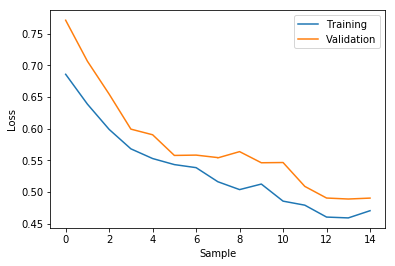

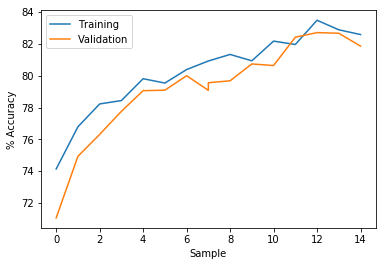

In [47]:

# Go back up and try a few different networks and initialization strategies
# Plot loss if you want
a, b = zip(*validationLosses)
plt.plot(trainingLosses, label="Training")
plt.plot(a, b, label="Validation")
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Loss')
plt.show()

# Plot accuracy
a1, b1 = zip(*validationAccuracies)
plt.plot(trainingAccuracies, label="Training")
plt.plot(a1, b1, label="Validation")
plt.legend()
plt.xlabel('Sample')
plt.ylabel('% Accuracy')
plt.show()


In [48]:
# Compute and print the number of parameters in the model
print(sum([parameterSet.numel() for parameterSet in model.parameters()]))

1010960


___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.

The formula for calculating by hand is:

`Output_dimension = 1 + (input_dimension - kernel_size + (2*padding)) / stride)`

*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernel_size=(3, 3), padding=(1, 1)**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **(out_channels=65, kernel_size=(3, 3), padding=2, 2)**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **(out_channels=7, kernel_size=(3, 3), padding=(6, 6)**

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5, 5), padding=(2, 2)**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5, 5), padding=(3, 3)**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5, 5), padding=(9, 9)**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **(out_channels=10, kernel_size=(5, 3), padding=(1, 0)**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5, 3), padding=(2, 1)**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5, 3), padding=(3, 2)**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5, 3), padding=(9, 8)**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **(out_channels=10, kernel_size=(2, 4), padding=(0, 0)**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, , kernel_size=(1, 1), padding=(0, 0)**

**TODO:**

**DONE:**
* Answer all the questions above 


In [0]:
# Write some test code for checking the answers for these problems (example shown in the video)
inputChannels = 3
inputHeight = 10
inputWidth = 10
batchSize = 1

kernelSize = (3, 3)

# (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
convolutionLayer = nn.Conv2d(inputChannels, 10, kernelSize, padding=(0, 0))
print(convolutionLayer(torch.zeros(batchSize, inputChannels, inputHeight, inputWidth)).size())

# (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(3, 3), padding=(1, 1)
convolutionLayer = nn.Conv2d(inputChannels, 22, kernelSize, padding=(1, 1))
print(convolutionLayer(torch.zeros(batchSize, inputChannels, inputHeight, inputWidth)).size())

# (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : (out_channels=65, kernel_size=(3, 3), padding=2, 2)
convolutionLayer = nn.Conv2d(inputChannels, 65, kernelSize, padding=(2, 2))
print(convolutionLayer(torch.zeros(batchSize, inputChannels, inputHeight, inputWidth)).size())

# (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : (out_channels=7, kernel_size=(3, 3), padding=(6, 6)
convolutionLayer = nn.Conv2d(inputChannels, 7, kernelSize, padding=(6, 6))
print(convolutionLayer(torch.zeros(batchSize, inputChannels, inputHeight, inputWidth)).size())

kernelSize = (5, 5)

#(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
convolutionLayer = nn.Conv2d(inputChannels, 10, kernelSize, padding=(1, 1))
print(convolutionLayer(torch.zeros(batchSize, inputChannels, inputHeight, inputWidth)).size())

#(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 5), padding=(2, 2)
convolutionLayer = nn.Conv2d(inputChannels, 100, kernelSize, padding=(2, 2))
print(convolutionLayer(torch.zeros(batchSize, inputChannels, inputHeight, inputWidth)).size())

#(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 5), padding=(3, 3)
convolutionLayer = nn.Conv2d(inputChannels, 23, kernelSize, padding=(3, 3))
print(convolutionLayer(torch.zeros(batchSize, inputChannels, inputHeight, inputWidth)).size())
#(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 5), padding=(9, 9)
convolutionLayer = nn.Conv2d(inputChannels, 5, kernelSize, padding=(9, 9))
print(convolutionLayer(torch.zeros(batchSize, inputChannels, inputHeight, inputWidth)).size())

kernelSize = (5, 3)

#(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 3), padding=(1, 0)
convolutionLayer = nn.Conv2d(inputChannels, 10, kernelSize, padding=(1, 0))
print(convolutionLayer(torch.zeros(batchSize, inputChannels, inputHeight, inputWidth)).size())

#(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 3), padding=(2, 1)
convolutionLayer = nn.Conv2d(inputChannels, 100, kernelSize, padding=(2, 1))
print(convolutionLayer(torch.zeros(batchSize, inputChannels, inputHeight, inputWidth)).size())

#(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 3), padding=(3, 2)
convolutionLayer = nn.Conv2d(inputChannels, 23, kernelSize, padding=(3, 2))
print(convolutionLayer(torch.zeros(batchSize, inputChannels, inputHeight, inputWidth)).size())

#(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 3), padding=(9, 8)
convolutionLayer = nn.Conv2d(inputChannels, 5, kernelSize, padding=(9, 8))
print(convolutionLayer(torch.zeros(batchSize, inputChannels, inputHeight, inputWidth)).size())

kernelSize = (2, 4)

#(c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : (out_channels=10, kernel_size=(2, 4), padding=(0, 0)
convolutionLayer = nn.Conv2d(inputChannels, 10, kernelSize, padding=(0, 0))
print(convolutionLayer(torch.zeros(batchSize, inputChannels, inputHeight, inputWidth)).size())

kernelSize = (1, 1)

#(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, , kernel_size=(1, 1), padding=(0, 0)
convolutionLayer = nn.Conv2d(inputChannels, 22, kernelSize, padding=(0, 0))
print(convolutionLayer(torch.zeros(batchSize, inputChannels, inputHeight, inputWidth)).size())

torch.Size([1, 10, 8, 8])
torch.Size([1, 22, 10, 10])
torch.Size([1, 65, 12, 12])
torch.Size([1, 7, 20, 20])
torch.Size([1, 10, 8, 8])
torch.Size([1, 100, 10, 10])
torch.Size([1, 23, 12, 12])
torch.Size([1, 5, 24, 24])
torch.Size([1, 10, 8, 8])
torch.Size([1, 100, 10, 10])
torch.Size([1, 23, 12, 12])
torch.Size([1, 5, 24, 24])
torch.Size([1, 10, 9, 7])
torch.Size([1, 22, 10, 10])
